/tmp/ipykernel_298202/1044341191.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


[11.]
[3.65917969]
4k write parfs/odin: [3.00613824]


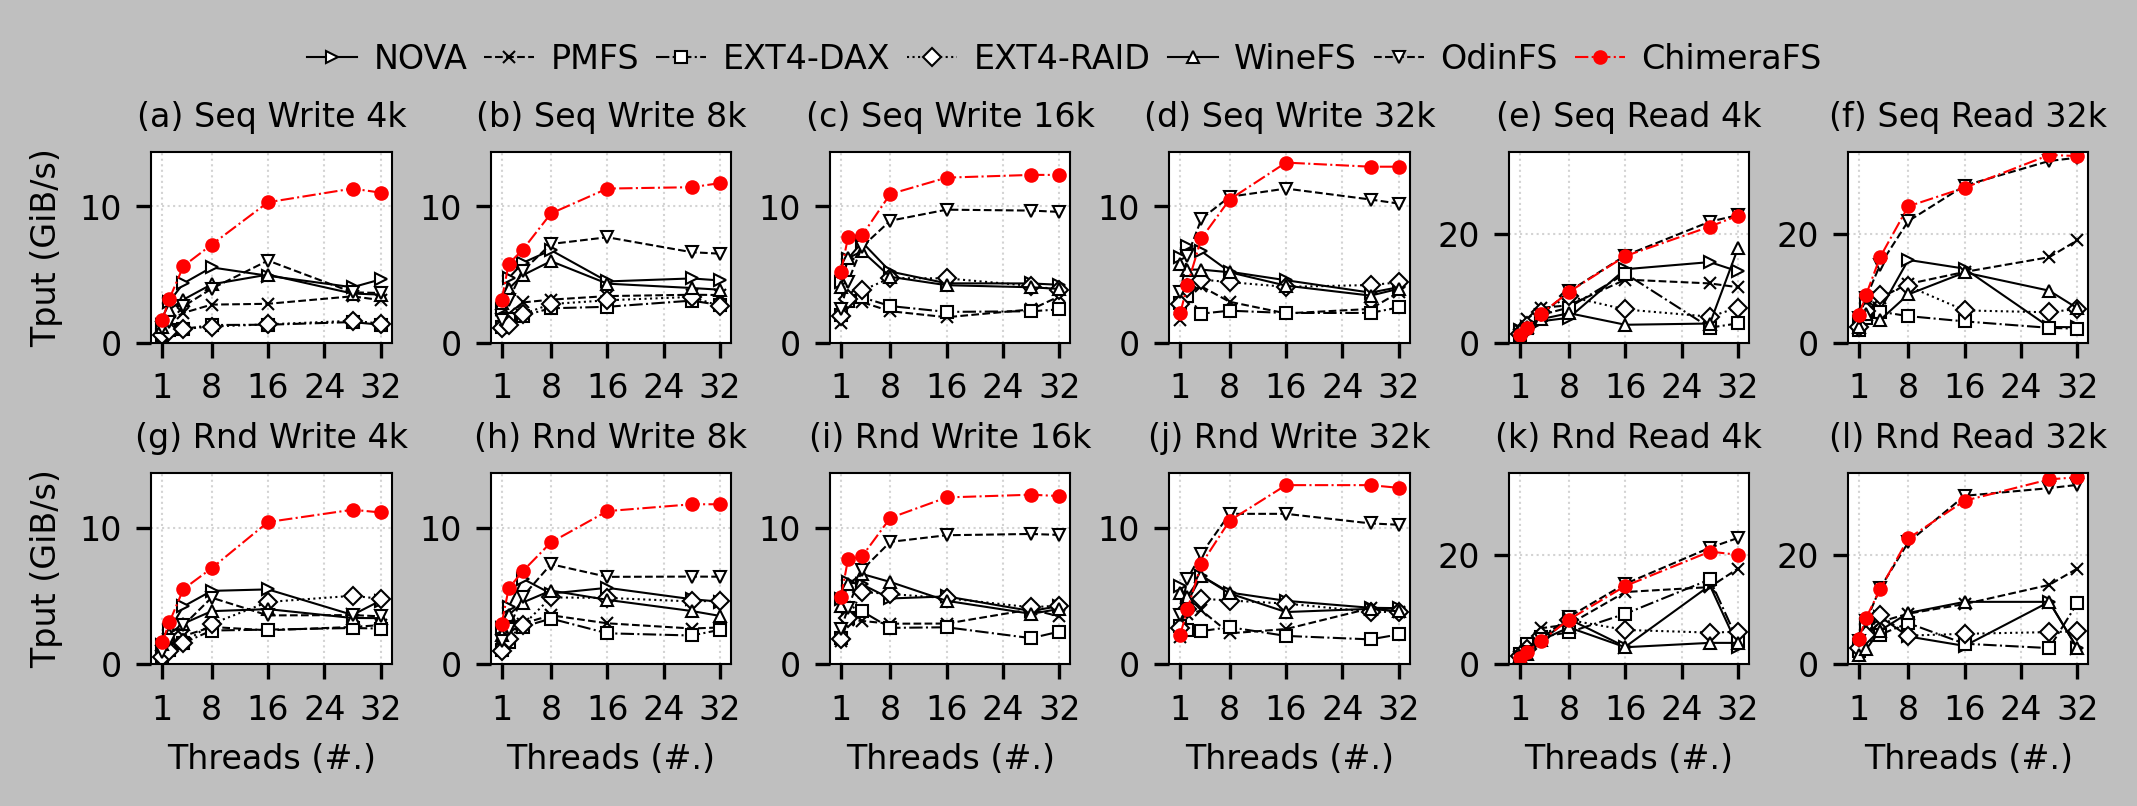

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi=300, figsize=(cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(6)))

line_width = 0.5
marks = [">", "x", "s", "D", "^", "v", "o"]
line_patterns = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
fss = ["nova", "pmfs", "ext4-dax", "ext4-raid", "winefs", "odinfs-12", "parfs-12"]
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs)
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024

mapping = {
    "nova": "NOVA",
    "pmfs": "PMFS",
    "ext4-dax": "EXT4-DAX",
    "ext4-raid": "EXT4-RAID",
    "winefs": "WineFS",
    "odinfs-12": "OdinFS",
    "parfs-12": "ChimeraFS",
    # "idel-12": "Ideal-FS"
}
mapped_fss = [mapping.get(item, item) for item in fss]

subplot_config = [
    # Upper row
    {'row': 0, 'col': 0, 'op': 'write', 'blksz': 4096, 'title_label': 'a', 'y_lims': [0, 14]},
    {'row': 0, 'col': 1, 'op': 'write', 'blksz': 8192, 'title_label': 'b', 'y_lims': [0, 14]},
    {'row': 0, 'col': 2, 'op': 'write', 'blksz': 16384, 'title_label': 'c', 'y_lims': [0, 14]},
    {'row': 0, 'col': 3, 'op': 'write', 'blksz': 32768, 'title_label': 'd', 'y_lims': [0, 14]},
    {'row': 0, 'col': 4, 'op': 'read', 'blksz': 4096, 'title_label': 'e', 'y_lims': [0, 35]},
    {'row': 0, 'col': 5, 'op': 'read', 'blksz': 32768, 'title_label': 'f', 'y_lims': [0, 35]},
    # Lower row
    {'row': 1, 'col': 0, 'op': 'randwrite', 'blksz': 4096, 'title_label': 'g', 'y_lims': [0, 14]},
    {'row': 1, 'col': 1, 'op': 'randwrite', 'blksz': 8192, 'title_label': 'h', 'y_lims': [0, 14]},
    {'row': 1, 'col': 2, 'op': 'randwrite', 'blksz': 16384, 'title_label': 'i', 'y_lims': [0, 14]},
    {'row': 1, 'col': 3, 'op': 'randwrite', 'blksz': 32768, 'title_label': 'j', 'y_lims': [0, 14]},
    {'row': 1, 'col': 4, 'op': 'randread', 'blksz': 4096, 'title_label': 'k', 'y_lims': [0, 35]},
    {'row': 1, 'col': 5, 'op': 'randread', 'blksz': 32768, 'title_label': 'l', 'y_lims': [0, 35]},
]

op_type_map = {
    'write': 'Seq Write',
    'randwrite': 'Rnd Write',
    'read': 'Seq Read',
    'randread': 'Rnd Read'
}

blksz_str_map = {
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k'
}

parfs_perf=df[(df['fs'] == "parfs-12") & (df['ops'] == "write") & (df['blksz'] == 4096) & (df['numjobs'] == 32)]['bandwidth'].values
print(parfs_perf)

odinfs_perf=df[(df['fs'] == "odinfs-12") & (df['ops'] == "write") & (df['blksz'] == 4096) & (df['numjobs'] == 32)]['bandwidth'].values
print(odinfs_perf)

write_perf=parfs_perf/odinfs_perf

print(f"4k write parfs/odin: {write_perf}")

lines = []
for i, config in enumerate(subplot_config):
    plt.subplot(2, 6, i+1)
    op = config['op']
    blksz = config['blksz']
    
    op_type = op_type_map[op]
    blksz_str = blksz_str_map[blksz]
    plt.title(f"({config['title_label']}) {op_type} {blksz_str}", fontsize=8)
    
    for fs_idx, fs in enumerate(fss):
        data = df[(df['fs'] == fs) & (df['ops'] == op) & (df['blksz'] == blksz)]
        y = data['bandwidth'].iloc[:len(num_jobs)]
        
        if len(x) != len(y):
            print(f"Data mismatch: {fs} {op} {blksz}")
            continue
        
        markercolor = "red" if fs == "parfs-12" else "white"
        markeredgecolor = "red" if fs == "parfs-12" else "black"
        color = "red" if fs == "parfs-12" else "black"
        if i == 0:  # Only add labels to first subplot
            p, = plt.plot(x, y, color=color, marker=marks[fs_idx],
                          markerfacecolor=markercolor, markeredgecolor=markeredgecolor,
                          markersize=3, markeredgewidth=0.5,
                          linewidth=line_width, label=mapped_fss[fs_idx], linestyle=line_patterns[fs_idx])
            lines.append(p)
        else:
            plt.plot(x, y, color=color, marker=marks[fs_idx],
                     markerfacecolor=markercolor, markeredgecolor=markeredgecolor,
                     markersize=3, markeredgewidth=0.5,
                     linewidth=line_width, label='_nolegend_', linestyle=line_patterns[fs_idx])

    # Axis labels
    if config['col'] == 0:
        plt.ylabel('Tput (GiB/s)', fontsize=8)
    if config['row'] == 1:
        plt.xlabel('Threads (#.)', fontsize=8)
    
    # Formatting
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32], fontsize=8)
    plt.ylim(config['y_lims'])
    plt.yticks(fontsize=8)
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    # plt.tick_params(left=True, bottom=True, right=False, top=False, which='major', width=0.5, length=3)

fig.legend(lines, mapped_fss, loc='upper center', 
          bbox_to_anchor=(0.5, 1.1), ncol=8,
          columnspacing=0.5, handletextpad=0.5, 
          handlelength=1.5, frameon=False, fontsize=8,)

# plt.subplots_adjust(left=0.06, right=0.98, top=0.88, bottom=0.08,
#                    hspace=0.3, wspace=0.25)
plt.tight_layout(pad=0.4)
plt.savefig("./FIO-MT.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
#!/usr/bin/env python3
import pandas as pd

# ① 读文件。原始标题里的括号不方便做列名，先全部读成字符串后重命名
df = pd.read_csv(
    "./performance-comparison-table",
    delim_whitespace=True,
    header=0,
    names=["fs", "ops", "filesz", "blksz", "numjobs", "bandwidth"]
)

# ② 只取 read 且 numjobs==32
cond = (df["ops"] == "write") & (df["numjobs"] == 32)
df32 = df[cond].copy()

# ③ 分出基准(parfs-12)和其他文件系统
parfs = df32[df32["fs"] == "parfs-12"][["filesz", "blksz", "bandwidth"]]
parfs = parfs.rename(columns={"bandwidth": "parfs_bw"})

others = df32[(df32["fs"] != "parfs-12") & (df32["fs"] != "odinfs-12")][
    ["fs", "filesz", "blksz", "bandwidth"]
]

# ④ 以 filesz+blksz 对齐，计算比值
merged = others.merge(parfs, on=["filesz", "blksz"], how="inner")
merged["ratio"] = merged["parfs_bw"] / merged["bandwidth"]

# ⑤ 求最小和最大
min_row = merged.loc[merged["ratio"].idxmin()]
max_row = merged.loc[merged["ratio"].idxmax()]

print("===== 最小比值 =====")
print(
    f"目标 FS : {min_row.fs}\n"
    f"filesz  : {min_row.filesz}\n"
    f"blksz   : {min_row.blksz}\n"
    f"parfs_bw: {min_row.parfs_bw:.1f} MiB/s\n"
    f"other_bw: {min_row.bandwidth:.1f} MiB/s\n"
    f"比值    : {min_row.ratio:.3f}"
)

print("\n===== 最大比值 =====")
print(
    f"目标 FS : {max_row.fs}\n"
    f"filesz  : {max_row.filesz}\n"
    f"blksz   : {max_row.blksz}\n"
    f"parfs_bw: {max_row.parfs_bw:.1f} MiB/s\n"
    f"other_bw: {max_row.bandwidth:.1f} MiB/s\n"
    f"比值    : {max_row.ratio:.3f}"
)

# （可选）想整体看看排名，可取消下一行注释
# print(merged.sort_values("ratio"))

# ⑥ 计算 parfs-12 与 odinfs-12 的带宽比值
odinfs = df32[df32["fs"] == "odinfs-12"][["filesz", "blksz", "bandwidth"]]
odinfs = odinfs.rename(columns={"bandwidth": "odinfs_bw"})

# 与 parfs-12 对齐计算比值
parfs_vs_odin = parfs.merge(odinfs, on=["filesz", "blksz"], how="inner")
parfs_vs_odin["ratio"] = parfs_vs_odin["parfs_bw"] / parfs_vs_odin["odinfs_bw"]

# 求最小和最大比值
min_po = parfs_vs_odin.loc[parfs_vs_odin["ratio"].idxmin()]
max_po = parfs_vs_odin.loc[parfs_vs_odin["ratio"].idxmax()]

print("\n===== parfs-12 / odinfs-12 最小比值 =====")
print(
    f"filesz      : {min_po.filesz}\n"
    f"blksz       : {min_po.blksz}\n"
    f"parfs_bw    : {min_po.parfs_bw:.1f} MiB/s\n"
    f"odinfs_bw   : {min_po.odinfs_bw:.1f} MiB/s\n"
    f"比值        : {min_po.ratio:.3f}"
)

print("\n===== parfs-12 / odinfs-12 最大比值 =====")
print(
    f"filesz      : {max_po.filesz}\n"
    f"blksz       : {max_po.blksz}\n"
    f"parfs_bw    : {max_po.parfs_bw:.1f} MiB/s\n"
    f"odinfs_bw   : {max_po.odinfs_bw:.1f} MiB/s\n"
    f"比值        : {max_po.ratio:.3f}"
)


===== 最小比值 =====
目标 FS : nova
filesz  : 1024
blksz   : 8192
parfs_bw: 11980.8 MiB/s
other_bw: 4568.0 MiB/s
比值    : 2.623

===== 最大比值 =====
目标 FS : ext4-raid
filesz  : 1024
blksz   : 4096
parfs_bw: 12083.2 MiB/s
other_bw: 1193.0 MiB/s
比值    : 10.128

===== parfs-12 / odinfs-12 最小比值 =====
filesz      : 1024.0
blksz       : 32768.0
parfs_bw    : 13414.4 MiB/s
odinfs_bw   : 10547.2 MiB/s
比值        : 1.272

===== parfs-12 / odinfs-12 最大比值 =====
filesz      : 1024.0
blksz       : 4096.0
parfs_bw    : 12083.2 MiB/s
odinfs_bw   : 3788.0 MiB/s
比值        : 3.190


/tmp/ipykernel_243728/568938863.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
